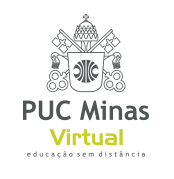

# Relatório Técnico PUC - Rui Oliveira Lima

## - Desenvolvimento de um modelo de detecção de fraude em comércio eletrônico usando aprendizado de máquina

### Source: Kaggle





####Referências

Kaggle Fraud Detection: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection



### Preparação Ambiente


In [1]:
#Criação ambiente
!python3 -m venv puc
#ativação
!source puc/bin/activate

Error: Command '['/content/puc/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: puc/bin/activate: No such file or directory


In [2]:
# Importações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive

### 1 - CA - 1.1 - Seleção Base de dados

#### Descrição dos dados (número de instâncias e atributos e os tipos de dados). 

In [3]:
# 1.1 Carregamento dataset
# Montar o Google Drive
drive.mount('/content/drive')

# Caminho do arquivo no Google Drive
caminho_arquivo = '/content/drive/MyDrive/onlinefraud.csv'

# Carregar o arquivo CSV
df = pd.read_csv(caminho_arquivo)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# 1.2 Obter o número de instâncias
num_instancias = df.shape[0]

# Exibir o número de instâncias
print("Número de instâncias:", num_instancias)

Número de instâncias: 6362620


In [6]:
# 1.3 Obter o número de atributos
num_atributos = df.shape[1]

# Exibir o número de atributos
print("Número de atributos:", num_atributos)

Número de atributos: 11


In [7]:
# 1.4 Obter os tipos de atributos
tipos_atributos = df.dtypes

# Exibir os tipos de atributos
print(tipos_atributos)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [8]:
df.shape


(6362620, 11)

### C.A - 1.2 - Descrição detalhada do tratamento da base de dados
#### Pré-processamento 

In [9]:
# 1.5 Verificação dados faltantes e Nulls

print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
# 1.6 Exploração tipo de transação

print(df.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [11]:
type = df["type"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(df, values=quantity, names=transactions, hole = 0.5, title="Distribuição tipo de transação")
figure.show()

In [12]:
# Aplicar codificação one-hot para coluna 'type'
df = pd.get_dummies(df, columns=['type'])
df.head(5)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [13]:
# 1.8 Tratamento dados ausentes

# Verificar dados ausentes em cada coluna do DataFrame
dados_ausentes = df.isnull().sum()

# Exibir contagem de dados ausentes em cada coluna
print(dados_ausentes)

# Verificar se há dados ausentes em todo o DataFrame
if df.isnull().any().any():
    print("Existem dados ausentes no DataFrame.")
else:
    print("Não há dados ausentes no DataFrame.")


step              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_IN      0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64
Não há dados ausentes no DataFrame.


In [14]:
# 1.9 remoção de colunas desnecessárias
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df.head(5)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Normalização dos valores numéricos
scaler = MinMaxScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(df[
    ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])


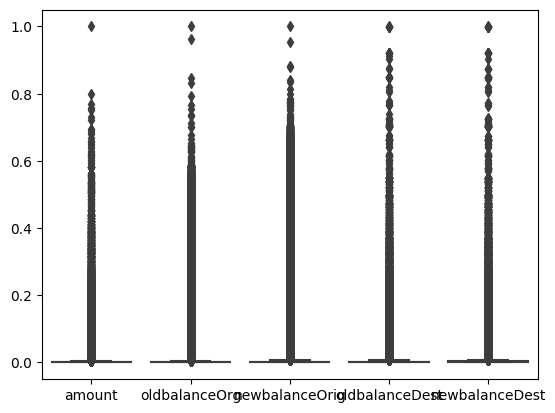

In [16]:
import seaborn as sns

# Boxplot dos atributos numéricos
sns.boxplot(data=df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
plt.show()

# Tratamento dos outliers usando Z-score
from scipy.stats import zscore

z_scores = zscore(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
df_no_outliers = df[(z_scores < 3).all(axis=1)]


### C.A - 1.3 - Análise, Exploração e Visualização dos Dados
#### Análises estatísticas dos dados, gráficos e/ou tabelas e as suas características.

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1  0.000106       0.002855        0.003233        0.000000   
1     1  0.000020       0.000357        0.000391        0.000000   
2     1  0.000002       0.000003        0.000000        0.000000   
3     1  0.000002       0.000003        0.000000        0.000059   
4     1  0.000126       0.000697        0.000603        0.000000   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_IN  type_CASH_OUT  \
0             0.0        0               0             0              0   
1             0.0        0               0             0              0   
2             0.0        1               0             0              0   
3             0.0        1               0             0              1   
4             0.0        0               0             0              0   

   type_DEBIT  type_PAYMENT  type_TRANSFER  
0           0             1              0  
1           0             1              0  
2    

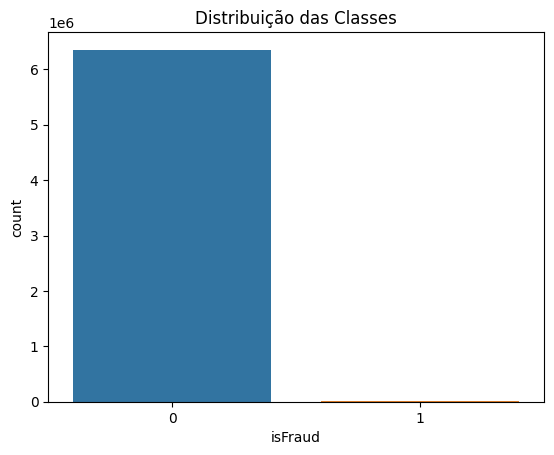

In [18]:
# Verificar as primeiras linhas do DataFrame
print(df.head())

# Verificar informações sobre o conjunto de dados
print(df.info())

# Verificar estatísticas descritivas
print(df.describe())

# Verificar distribuição das classes
sns.countplot(data=df, x='isFraud')
plt.title('Distribuição das Classes')
plt.show()

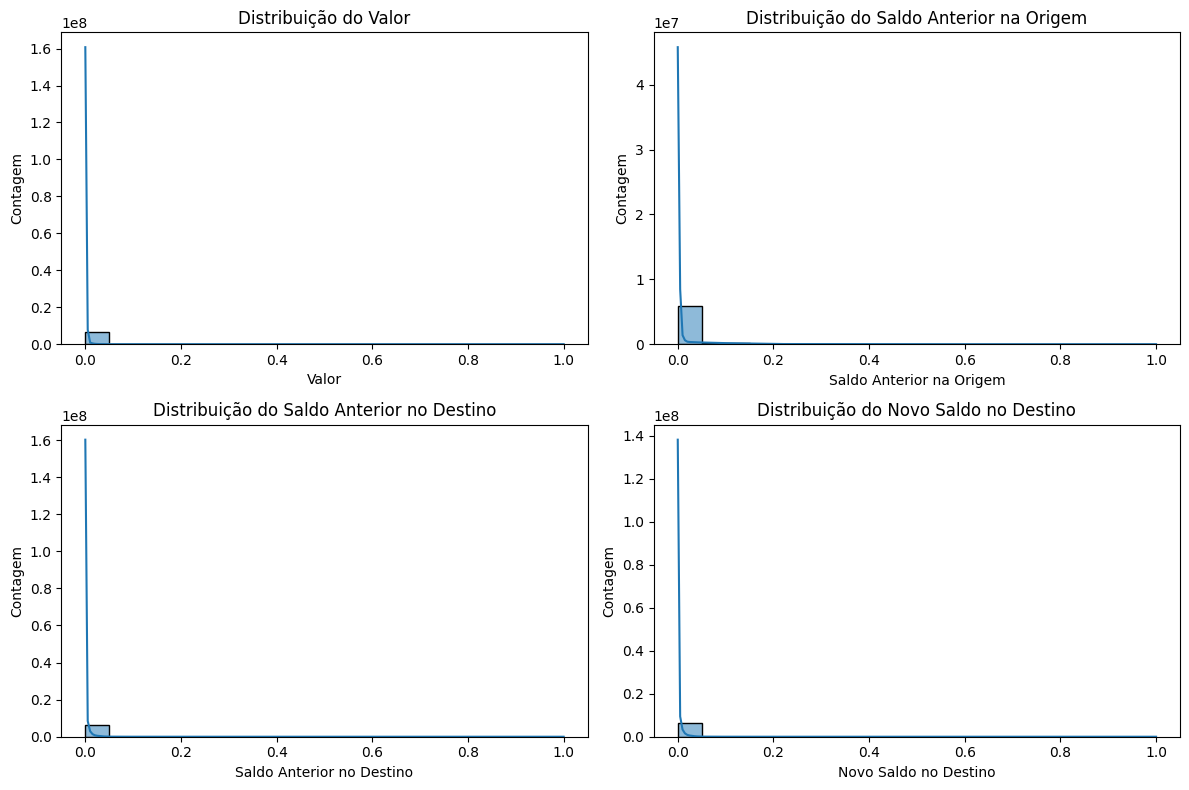

In [19]:
# Verificar a distribuição das variáveis numéricas
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(data=df, x='amount', bins=20, kde=True)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Distribuição do Valor')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='oldbalanceOrg', bins=20, kde=True)
plt.xlabel('Saldo Anterior na Origem')
plt.ylabel('Contagem')
plt.title('Distribuição do Saldo Anterior na Origem')

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='oldbalanceDest', bins=20, kde=True)
plt.xlabel('Saldo Anterior no Destino')
plt.ylabel('Contagem')
plt.title('Distribuição do Saldo Anterior no Destino')

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='newbalanceDest', bins=20, kde=True)
plt.xlabel('Novo Saldo no Destino')
plt.ylabel('Contagem')
plt.title('Distribuição do Novo Saldo no Destino')

plt.tight_layout()
plt.show()


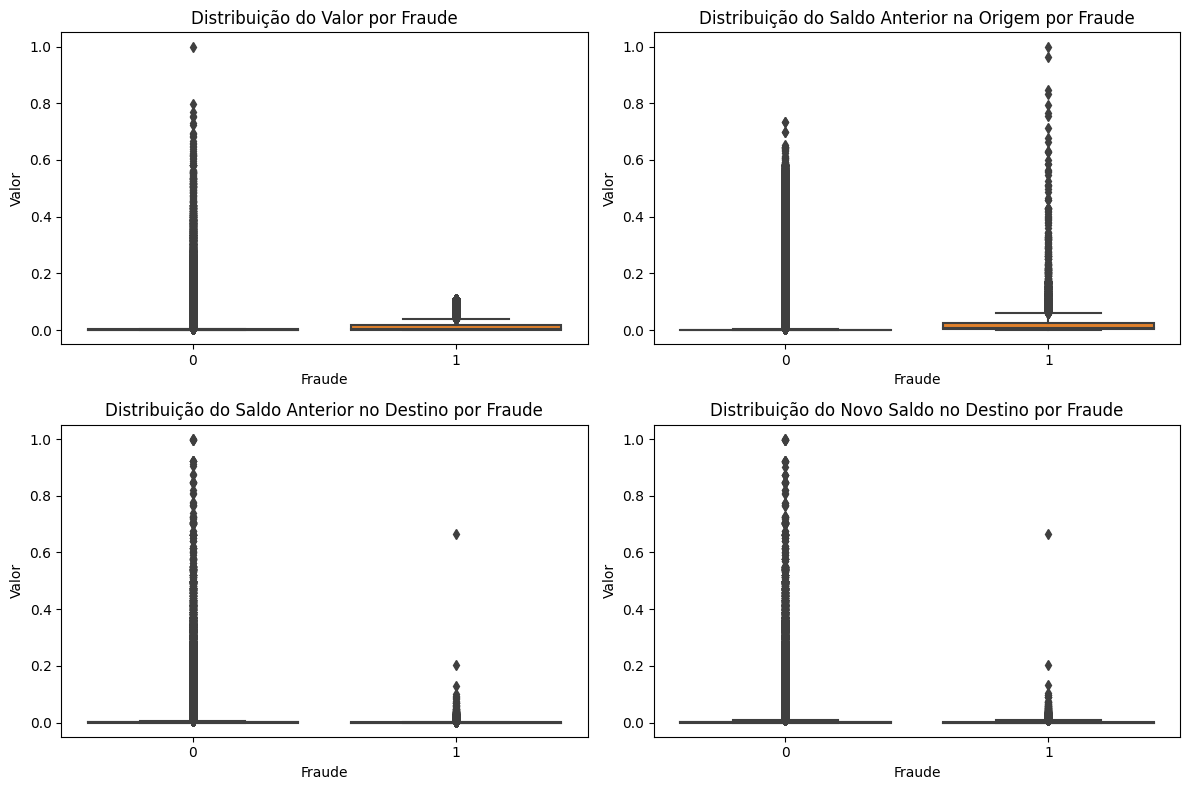

In [20]:
# Verificar a distribuição das fraudes em relação a outras variáveis numéricas
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='isFraud', y='amount')
plt.xlabel('Fraude')
plt.ylabel('Valor')
plt.title('Distribuição do Valor por Fraude')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='isFraud', y='oldbalanceOrg')
plt.xlabel('Fraude')
plt.ylabel('Valor')
plt.title('Distribuição do Saldo Anterior na Origem por Fraude')

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='isFraud', y='oldbalanceDest')
plt.xlabel('Fraude')
plt.ylabel('Valor')
plt.title('Distribuição do Saldo Anterior no Destino por Fraude')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='isFraud', y='newbalanceDest')
plt.xlabel('Fraude')
plt.ylabel('Valor')
plt.title('Distribuição do Novo Saldo no Destino por Fraude')

plt.tight_layout()
plt.show()


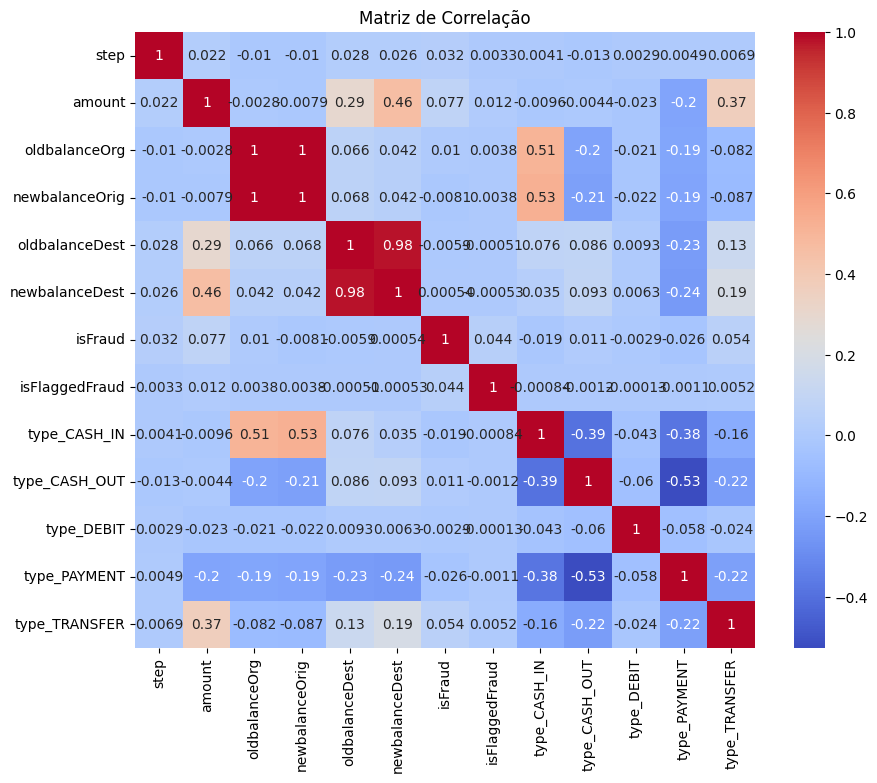

In [21]:
#Análise de correção
# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Plotar um mapa de calor (heatmap) da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


In [22]:
from scipy.stats import ttest_ind

# Comparar a média das variáveis entre fraudes e não fraudes
fraud_data = df[df['isFraud'] == 1]
non_fraud_data = df[df['isFraud'] == 0]

t_statistic, p_value = ttest_ind(fraud_data['amount'], non_fraud_data['amount'])
print("Teste de Hipótese - Valor-P:", p_value)


Teste de Hipótese - Valor-P: 0.0


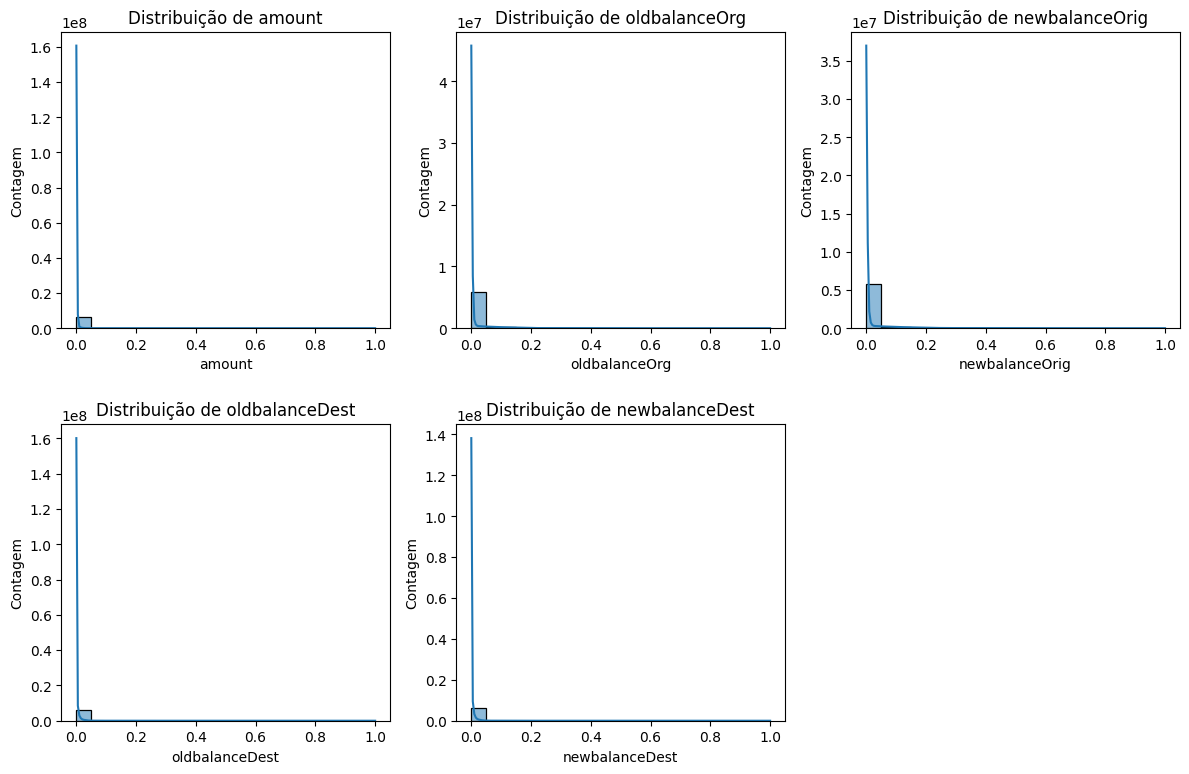

In [23]:
# Análise univariada das variáveis numéricas
numeric_vars = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(12, 8))

for i, var in enumerate(numeric_vars):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=var, bins=20, kde=True)
    plt.xlabel(var)
    plt.ylabel('Contagem')
    plt.title('Distribuição de {}'.format(var))

plt.tight_layout()
plt.show()


In [24]:
!pip install -q seaborn==0.11.2

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar a renderização do matplotlib para o Colab
%matplotlib inline


In [ ]:
sns.pairplot(df[numeric_vars + ['isFraud']], hue='isFraud')
plt.show()

###C.A - 2.1 - Preparação de Dados para o Modelo
####Documentação dos tratamentos específicos dos dados de acordo com os modelos de Aprendizado de Máquina a serem utilizados no trabalho

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [38]:
# Separar os atributos e a variável alvo
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [39]:
# Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

# Oversampling
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

In [41]:
# Divisão da base de dados para treino, validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_undersampled, y_undersampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42)

In [42]:
# Verificar as proporções das classes após o undersampling
print("Proporção de classes após undersampling:")
print(pd.Series(y_undersampled).value_counts(normalize=True))

Proporção de classes após undersampling:
0    0.5
1    0.5
Name: isFraud, dtype: float64


In [43]:
# Verificar as proporções das classes após o oversampling
print("Proporção de classes após oversampling:")
print(pd.Series(y_oversampled).value_counts(normalize=True))

Proporção de classes após oversampling:
0    0.5
1    0.5
Name: isFraud, dtype: float64


In [44]:
# Imprimir o tamanho de cada conjunto de dados
print("Tamanho da base de treino:", X_train.shape[0])
print("Tamanho da base de validação:", X_val.shape[0])
print("Tamanho da base de teste:", X_test.shape[0])

Tamanho da base de treino: 9855
Tamanho da base de validação: 3285
Tamanho da base de teste: 3286


### C.A - 2.2 Aplicação dos Modelos de Aprendizado de Máquina
#### Implementação de algoritmo de Aprendizado de Máquina, e parâmetros de configuração.

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Criação do modelo Random Forest
rf_model = RandomForestClassifier()

# Treinamento do modelo
rf_model.fit(X_train, y_train)

# Avaliação do modelo
accuracy = rf_model.score(X_test, y_test)
print("Acurácia do modelo Random Forest:", accuracy)


Acurácia do modelo Random Forest: 0.9920876445526476


In [46]:
from sklearn.linear_model import LogisticRegression

# Criação do modelo de regressão logística
lr_model = LogisticRegression()

# Treinamento do modelo
lr_model.fit(X_train, y_train)

# Avaliação do modelo
accuracy = lr_model.score(X_test, y_test)
print("Acurácia do modelo de Regressão Logística:", accuracy)


Acurácia do modelo de Regressão Logística: 0.8018867924528302


In [55]:
from sklearn.ensemble import GradientBoostingClassifier

# Criação do modelo Gradient Boosting
gb_model = GradientBoostingClassifier()

# Treinamento do modelo
gb_model.fit(X_train, y_train)

# Avaliação do modelo
accuracy = gb_model.score(X_test, y_test)
print("Acurácia do modelo Gradient Boosting:", accuracy)

Acurácia do modelo Gradient Boosting: 0.9914790018259282


### C.A 2.3 - Análise dos Resultados a partir da Aplicação de Métricas de Avaliação
#### Métricas de avaliação do modelo de Aprendizado de Máquina

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1_score = f1_score(y_test, rf_predictions)

print("Random Forest:")
print("Acurácia:", rf_accuracy)
print("Precisão:", rf_precision)
print("Recall:", rf_recall)
print("F1-Score:", rf_f1_score)

Random Forest:
Acurácia: 0.9920876445526476
Precisão: 0.9867069486404834
Recall: 0.9975565058032987
F1-Score: 0.9921020656136088


In [57]:
# Logistic Regression
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_f1_score = f1_score(y_test, lr_predictions)

print("Logistic Regression:")
print("Acurácia:", lr_accuracy)
print("Precisão:", lr_precision)
print("Recall:", lr_recall)
print("F1-Score:", lr_f1_score)

Logistic Regression:
Acurácia: 0.8018867924528302
Precisão: 0.7679347826086956
Recall: 0.8631643249847282
F1-Score: 0.8127696289905091


In [58]:
# Gradient Boosting
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_f1_score = f1_score(y_test, gb_predictions)

print("Gradient Boosting:")
print("Acurácia:", gb_accuracy)
print("Precisão:", gb_precision)
print("Recall:", gb_recall)
print("F1-Score:", gb_f1_score)

Gradient Boosting:
Acurácia: 0.9914790018259282
Precisão: 0.9855159927579964
Recall: 0.9975565058032987
F1-Score: 0.9914996964177292


<ipython-input-64-52e7b6cc1712>:14: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



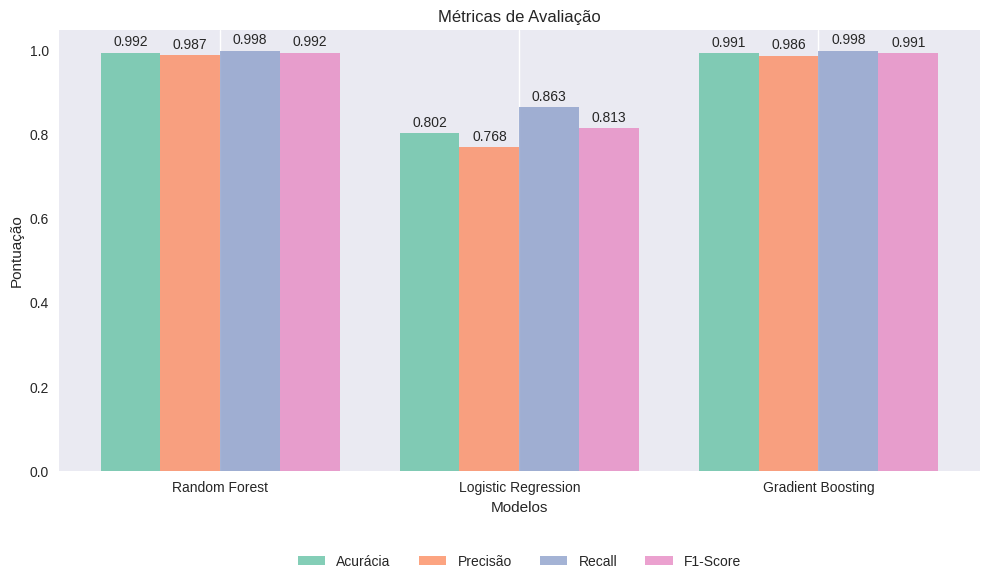

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Lista com os nomes dos modelos
model_names = ['Random Forest', 'Logistic Regression', 'Gradient Boosting']

# Lista com as métricas de acurácia, precisão, recall e F1-Score para cada modelo
accuracy_scores = [rf_accuracy, lr_accuracy, gb_accuracy]
precision_scores = [rf_precision, lr_precision, gb_precision]
recall_scores = [rf_recall, lr_recall, gb_recall]
f1_scores = [rf_f1_score, lr_f1_score, gb_f1_score]

# Configurações de estilo do gráfico
plt.style.use('seaborn')
palette = plt.get_cmap('Set2')
x = np.arange(len(model_names))

# Gráfico de barras para comparar as métricas
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
rects1 = ax.bar(x, accuracy_scores, width=bar_width, align='center', label='Acurácia', alpha=0.8, color=palette(0))
rects2 = ax.bar(x + bar_width, precision_scores, width=bar_width, align='center', label='Precisão', alpha=0.8, color=palette(1))
rects3 = ax.bar(x + (2 * bar_width), recall_scores, width=bar_width, align='center', label='Recall', alpha=0.8, color=palette(2))
rects4 = ax.bar(x + (3 * bar_width), f1_scores, width=bar_width, align='center', label='F1-Score', alpha=0.8, color=palette(3))

# Configurações dos eixos e legendas
ax.set_xticks(x + (1.5 * bar_width))
ax.set_xticklabels(model_names)
ax.set_ylabel('Pontuação')
ax.set_xlabel('Modelos')
ax.set_title('Métricas de Avaliação')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4)

# Remover linhas de grade
ax.yaxis.grid(False)

# Adicionar valores no topo de cada coluna
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Ajuste do layout
plt.tight_layout()

# Exibição do gráfico
plt.show()

